<a href="https://colab.research.google.com/github/linesn/reddit_analysis/blob/main/Sentiment_Analysis_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis Exercise 
Nicholas Lines  
EN.605.633.81.SP21 Social Media Analytics  

## Introduction
This notebook is my response to the prompt to train a sentiment analysis classifier using [NLTK](https://www.nltk.org/) and [the Sentiment140 corpus](http://help.sentiment140.com/for-students), which was introduced in [1]. As instructed, we'll follow [the tutorial](https://www.laurentluce.com/posts/twitter-sentiment-analysis-using-python-and-nltk/) written by Laurent Luce. The result (both of the tutorial and what we'll make here) is a document (tweet) level binary positive/negative classifier using bag-of-words features. The resulting classifier is purely for learning and demonstration purposes, and is not fit for use in real applications -- for real English language sentiment analysis projects I recommend [VADER](https://github.com/cjhutto/vaderSentiment) for lexical rules-based decisions at the sentence or document level, or something like [the Stanford NLP approach](https://nlp.stanford.edu/sentiment/) for supervised modeling. 

## Setting up the environment

In [1]:
%pylab inline
import pandas as pd
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
try:
  import langdetect
except:
  ! pip install langdetect
  import langdetect

In [3]:
try:
  from vaderSentiment import vaderSentiment
except:
  ! pip install vaderSentiment
  from vaderSentiment import vaderSentiment

     |████████████████████████████████| 133kB 4.2MB/s 


In [4]:
# from sklearn.naive_bayes import MultinomialNB

In [5]:
from tqdm.notebook import tqdm

In [6]:
import pickle

In [7]:
import nltk

In [8]:
if 'COLAB_GPU' in os.environ: # a hacky way of determining if you are in colab.
  print("Notebook is running in colab")
  from google.colab import drive
  drive.mount("/content/drive")
  DATA_DIR = "drive/MyDrive/Data/raw/"
  
else:
  # Get the system information from the OS
  PLATFORM_SYSTEM = platform.system()

  # Darwin is macOS
  if PLATFORM_SYSTEM == "Darwin":
      EXECUTABLE_PATH = Path("../dependencies/chromedriver")
  elif PLATFORM_SYSTEM == "Windows":
      EXECUTABLE_PATH = Path("../dependencies/chromedriver.exe")
  else:
      logging.critical("Chromedriver not found or Chromedriver is outdated...")
      exit()
  DATA_DIR = "../Data/"

Notebook is running in colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Getting and preparing the training data
Note that the Sentiment140 data was gathered by querying Twitter for tweets including a given word (e.g. product name) AND emoticons that were used to declare a tweet Positive or Negative. The raw data is kept unchanged except the emoticons are removed. 

In [9]:
if not os.path.exists(DATA_DIR + "/training.1600000.processed.noemoticon.csv"):
  ! wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
  ! unzip trainingandtestdata.zip -d $DATA_DIR
  ! ls $DATA_DIR -lrt

The tweets in the corpus are labeled as follows  

| number | meaning  |  
| ------ | -------- |  
| 0      | negative |
| 2      | neutral  |
| 4      | positive |

In practice, though, the data seems to only include the negative and positive tweets. I also notice that there does not appear to be any language filtration in place, so we would want to add that in a real-life application with mixed data.


In [10]:
header = ["polarity", "tweet_id", "date", "query", "user", "text"]
df = pd.read_csv(DATA_DIR+"training.1600000.processed.noemoticon.csv", parse_dates=True, names=header, encoding="latin-1")
df.head()

,polarity,tweet_id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [11]:
df.shape

(1600000, 6)

In [12]:
df.polarity.value_counts()

4    800000
0    800000
Name: polarity, dtype: int64

In [13]:
lengths = array([len(i) for i in df["text"]])
pd.value_counts(lengths)

138    29850
137    22142
136    18793
48     16652
46     16616
       ...  
243        1
244        1
248        1
252        1
374        1
Length: 257, dtype: int64

In [14]:
df.isnull().any()

polarity    False
tweet_id    False
date        False
query       False
user        False
text        False
dtype: bool

The text encoding (`latin-1`) is inconvenient, so we'll change that.

In [15]:
df.text = df.text.apply (lambda row: row.encode("utf-8", "ignore").decode('utf-8','ignore'))

In [16]:
# df["lang"] = df.text.apply (lambda row: langdetect.detect(row))

In [17]:
negatives = df[df["polarity"]==0].text.to_numpy()
positives = df[df["polarity"]==4].text.to_numpy()

In [18]:
percent_train = .80
plim = int(len(positives) * percent_train)
nlim = int(len(negatives) * percent_train)
positives_train = positives[:plim]
positives_test = positives[plim:]
negatives_train = negatives[:nlim]
negatives_test = negatives[nlim:]

In [19]:
tweets = []
for words in positives_train:
    words_filtered = [e.lower() for e in words.split() if len(e) >= 3]
    tweets.append((words_filtered, 'positive'))
for words in negatives_train:
    words_filtered = [e.lower() for e in words.split() if len(e) >= 3]
    tweets.append((words_filtered, 'negative'))
test_tweets = []
for words in positives_test:
    words_filtered = [e.lower() for e in words.split() if len(e) >= 3]
    tweets.append((words_filtered, 'positive'))
for words in negatives_test:
    words_filtered = [e.lower() for e in words.split() if len(e) >= 3]
    tweets.append((words_filtered, 'negative'))

At this point we have to deviate from the tutorial heavily. The tutorial uses every vocabulary word as a feature, which is just not feasible when we have 1,191,165 vocabulary words (the result of including Twitter handles, no doubt). At my estimation, using all possible features and all of the training data would have taken about 10 weeks to complete the training. 

So we'll do some simple vocabulary pruning. We drop all terms that do not appear at least 5 times (since they won't help identify trends) and all terms that appear extremely frequently, using the minimum of the second differences in the ordered frequency counts to find an elbow. This drastically reduces our vocabulary size.

In [20]:
def elbowcut(list_object):
  list_object = sorted(list_object, reverse=True)
  d = [list_object[i+1]-list_object[i] for i in range(len(list_object)-1)]
  dd = [d[i+1]-d[i] for i in range(len(d) - 1)] 
  plot(dd)
  return list_object[argmin(dd)+2]


def get_words_in_tweets(tweets):
    all_words = []
    for (words, sentiment) in tweets:
      all_words.extend(words)
    return all_words


def get_word_features(wordlist):
    goodkeys = []
    wordlist = nltk.FreqDist(wordlist)
    #plot(sorted(list(wordlist.values()), reverse=True))
    cutoff = elbowcut(list(wordlist.values()))
    for key in wordlist:
      if wordlist[key] > 5 and wordlist[key] < cutoff:
        goodkeys.append(key) 
    word_features = set(goodkeys)
    return word_features


def extract_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

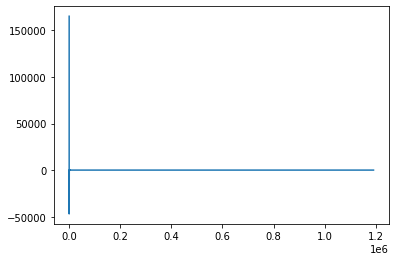

In [21]:
word_features = get_word_features(get_words_in_tweets(tweets))

In [22]:
len(word_features)

100198

In [23]:
training_set = nltk.classify.apply_features(extract_features, tweets)
testing_set = nltk.classify.apply_features(extract_features, test_tweets)

In [24]:
shortset = training_set[:10] + training_set[int(len(training_set)/2):int(len(training_set)/2+10)]
longset = training_set[:20] + training_set[int(len(training_set)/2):int(len(training_set)/2+20)]

## Building the classifier, training, and testing

Let's see how long training takes.

In [101]:
%%time
classifier = nltk.NaiveBayesClassifier.train(shortset)

CPU times: user 9.12 s, sys: 263 ms, total: 9.38 s
Wall time: 9.45 s


In [102]:
%%time
classifier = nltk.NaiveBayesClassifier.train(longset)

CPU times: user 16.4 s, sys: 112 ms, total: 16.5 s
Wall time: 16.7 s


In [105]:
t = (16.5 / 40) * df.shape[0] * percent_train / 60 # time in minutes
print("Given the 40 training iterations timing,\n\
 the full computation should be done in", t, "minutes")

Given the 40 training iterations timing,
 the full computation should be done in 8800.0 minutes


That is still more time than I can justify, so we'll have to only use part of the data.

If we were to go ahead and use this training method (perhaps on better hardware?) for the whole training dataset, we'd run the cells commented out below.

In [ ]:
# classifier = nltk.NaiveBayesClassifier.train(longset)
# with open(DATA_DIR+"/classifier.pkl", 'wb') as outfile:
#   pickle.dump(classifier, outfile) # If you train this all the way, you don't want to do it twice!
# print(classifier.classify(extract_features("this is a dumb sentence".split())))
# classifier.show_most_informative_features()

In [ ]:
# print("Training accuracy:", nltk.classify.accuracy(classifier, training_set))

In [ ]:
# print("Testing accuracy:",nltk.classify.accuracy(classifier, testing_set))

In [107]:
print("In 10 minutes I can train about", int(10 * 40/(16.5/60)), "iterations")

In 10 minutes I can train about 1454 iterations


Training on a subset of the full training set:

In [29]:
my_training = training_set[:500] + training_set[int(len(training_set)/2):int(len(training_set)/2+500)]
my_test = testing_set[:100] + testing_set[int(len(testing_set)/2):int(len(testing_set)/2+100)]

In [110]:
%%time
classifier = nltk.NaiveBayesClassifier.train(my_training)

CPU times: user 5min 25s, sys: 849 ms, total: 5min 26s
Wall time: 5min 27s


In [26]:
with open(DATA_DIR+"/classifier.pkl", 'rb') as infile:
  classifier = pickle.load(infile) 

## Testing

In [ ]:
with open(DATA_DIR+"/classifier.pkl", 'wb') as outfile:
  pickle.dump(classifier, outfile) # If you train this all the way, you don't want to do it twice!

In [27]:
print(classifier.classify(extract_features("this is a dumb sentence".split())))
classifier.show_most_informative_features()

negative
Most Informative Features
        contains(thanks) = True           positi : negati =     14.3 : 1.0
           contains(sad) = True           negati : positi =     11.7 : 1.0
         contains(never) = True           negati : positi =      9.0 : 1.0
          contains(glad) = True           positi : negati =      8.3 : 1.0
         contains(sucks) = True           negati : positi =      6.3 : 1.0
         contains(cause) = True           negati : positi =      5.7 : 1.0
          contains(too!) = True           positi : negati =      5.7 : 1.0
           contains(bad) = True           negati : positi =      5.4 : 1.0
           contains(hey) = True           positi : negati =      5.0 : 1.0
         contains(didnt) = True           negati : positi =      5.0 : 1.0


In [ ]:
print("Training accuracy:", nltk.classify.accuracy(classifier, my_training))

In [ ]:
print("Testing accuracy:",nltk.classify.accuracy(classifier, my_test))

## Results  
There are a few big lessons learned here. One is that feature engineering is as important as classifier choice when setting up this model. There are probably smarter feature engineering choices that could be made that would improve my approach quite a bit. It also appears that NLTK's Naive Bayes classifier implementation is really slow. I'd like to compare it to the sklearn implementation if I had more time.

## References
[1] Go, Alec, Richa Bhayani, and Lei Huang. "Twitter sentiment classification using distant supervision." CS224N project report, Stanford 1.12 (2009): 2009.
